In [1]:
from google.colab import drive
import sys

PROJECT_ROOT = '/content/drive/MyDrive/commit_test_folder/EECE491-01-Capstone-Design'

drive.mount('/content/drive')
sys.path.append(PROJECT_ROOT)

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [3]:
from google.colab.patches import cv2_imshow
from src.utils.viz_utils import render_tensor, draw_bounding_boxes
from src.models.face_autoencoder import FaceAutoencoder
from src.utils.data_utils import get_transform
from src.utils.io_utils import get_image_from_upload
from src.models.face_detector import FaceDetector
from src.utils.pls_utils import *

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_DIR = "/content/drive/MyDrive/models"
VISUALIZE_SNR_DB = 5.0
NUM_IMAGES_TO_SHOW = 4

MODEL_CONFIGS = [
    (512, "_512.pth", "MSE"),
    (512, "_512_SSIM.pth", "SSIM"),
    (512, "_512_SSIM_Augmentation.pth", "SSIM Augmentation")
]

이미지를 업로드해주세요.


Saving smiling-asian-young-woman-face-portrait_53876-145636.jpg to smiling-asian-young-woman-face-portrait_53876-145636 (2).jpg

1개의 얼굴을 찾았습니다.


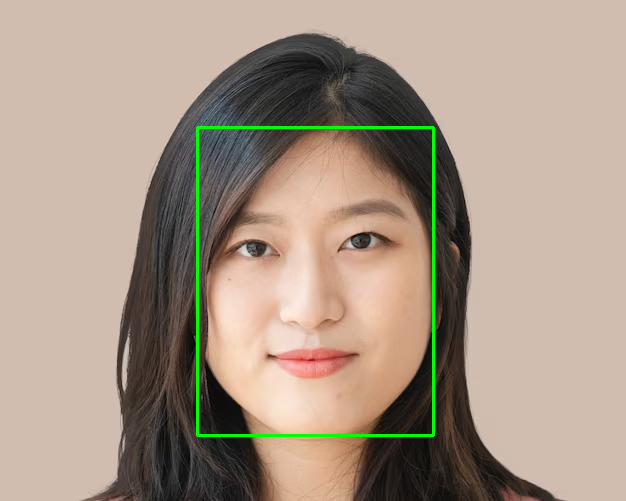

얼굴 #1


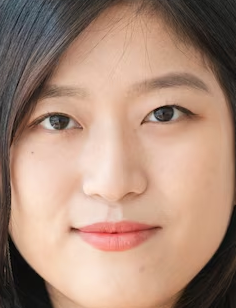

In [23]:
def resize_for_display(image, max_width=600):
    """
    이미지의 가로/세로 비율을 유지하면서, 최대 가로 크기를 max_width로 조절합니다.
    """
    try:
        h, w = image.shape[:2]
        if w <= max_width:
            return image

        ratio = max_width / float(w)
        new_height = int(h * ratio)

        resized = cv2.resize(image, (max_width, new_height), interpolation=cv2.INTER_AREA)
        return resized
    except Exception as e:
        print(f"[Error] Failed to resize image: {e}")
        return image

face_detector = FaceDetector()
_, transform = get_transform(128)
original_image = get_image_from_upload()

if original_image is not None:

    cropped_faces, final_boxes = face_detector.run(original_image, target_size=640, score_threshold=0.9)

    img_with_boxes = draw_bounding_boxes(original_image, final_boxes)

    print(f"\n{len(cropped_faces)}개의 얼굴을 찾았습니다.")

    display_original = resize_for_display(img_with_boxes, max_width=800)
    cv2_imshow(display_original)

    for i, face_img in enumerate(cropped_faces):
        print(f"얼굴 #{i+1}")

        display_face = resize_for_display(face_img, max_width=300)
        cv2_imshow(display_face)

In [24]:
image_list = []
for face_bgr in cropped_faces:
    face_pil = Image.fromarray(cv2.cvtColor(face_bgr, cv2.COLOR_BGR2RGB))
    input_tensor = transform(face_pil)
    image_list.append(input_tensor)

sample_images = torch.stack(image_list).to(device)
NUM_IMAGES_TO_SHOW = len(sample_images)

In [25]:
if NUM_IMAGES_TO_SHOW > 0:
    reconstruction_results = {}

for latent_dim, suffix, display_name in MODEL_CONFIGS:
    model_name = f"face_autoencoder{suffix}"
    MODEL_PATH = os.path.join(SAVE_DIR, model_name)
    print(f"\n--- Processing Model: {model_name} ---")

    model = FaceAutoencoder(latent_dim=latent_dim).to(device)
    try:
        model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
        model.eval()
        print("Model loaded successfully.")
    except FileNotFoundError:
        print(f"[ERROR] Model file not found at {MODEL_PATH}. Skipping.")
        reconstruction_results[display_name] = {'pristine': None, 'bob': None, 'eve': None}
        continue

    with torch.no_grad():
        latent_original = model.encode(sample_images)

        latent_bob, latent_eve = an_pls_channel(
            latent_original,
            snr_db=VISUALIZE_SNR_DB
            # (alpha=0.5, Nt=4, Ne=1 등 기본값 사용)
        )

        recon_pristine = model.decode(latent_original) # 1. 원본 (노이즈 X)
        recon_bob = model.decode(latent_bob)           # 2. Bob (보안 채널)
        recon_eve = model.decode(latent_eve)           # 3. Eve (도청 채널)

        reconstruction_results[display_name] = {
            'pristine': recon_pristine,
            'bob': recon_bob,
            'eve': recon_eve
        }


--- Processing Model: face_autoencoder_512.pth ---
Model loaded successfully.

--- Processing Model: face_autoencoder_512_SSIM.pth ---
Model loaded successfully.

--- Processing Model: face_autoencoder_512_SSIM_Augmentation.pth ---
Model loaded successfully.


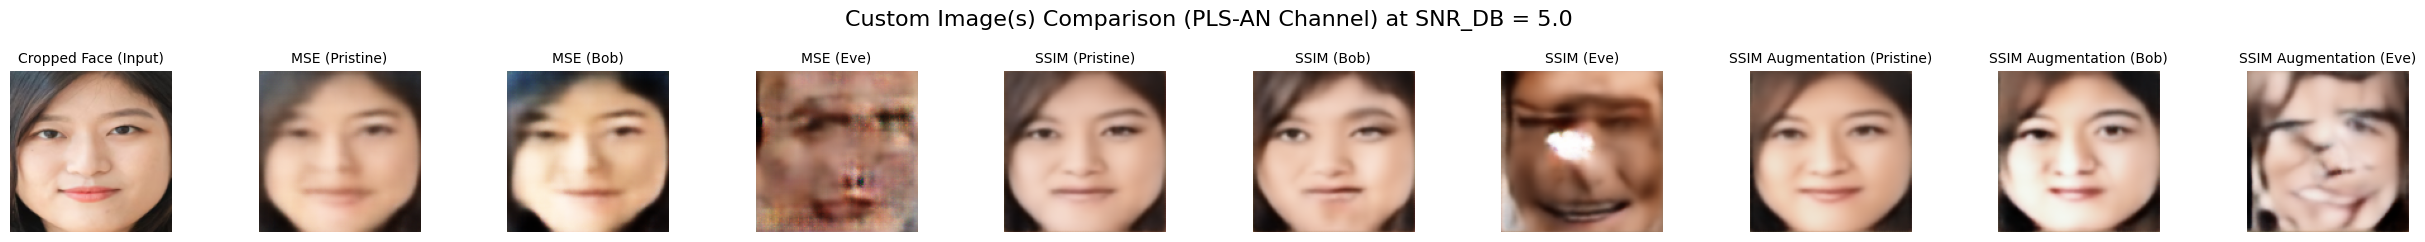

In [26]:
num_cols_per_image = 1 + len(MODEL_CONFIGS) * 3
num_rows = NUM_IMAGES_TO_SHOW

fig, axes = plt.subplots(num_rows, num_cols_per_image, figsize=(num_cols_per_image * 2.5, num_rows * 2.5))
if num_rows == 1:
    axes = np.expand_dims(axes, axis=0)

fig.suptitle(f"Custom Image(s) Comparison (PLS-AN Channel) at SNR_DB = {VISUALIZE_SNR_DB}", fontsize=16)

column_titles = ["Cropped Face (Input)"]
for _, _, display_name in MODEL_CONFIGS:
    column_titles.append(f"{display_name} (Pristine)")
    column_titles.append(f"{display_name} (Bob)")
    column_titles.append(f"{display_name} (Eve)")

for row_idx in range(NUM_IMAGES_TO_SHOW):

    original_title = f"Face #{row_idx + 1}"
    title_to_show = column_titles[0] if row_idx == 0 else None

    if num_rows > 1:
        axes[row_idx, 0].set_ylabel(original_title, fontsize=10, labelpad=20)

    render_tensor(axes[row_idx, 0], sample_images[row_idx],
           title=title_to_show)

    col_offset = 1
    for _, _, display_name in MODEL_CONFIGS:
        recons = reconstruction_results.get(display_name, {'pristine': None, 'bob': None, 'eve': None})

        # 1. Pristine 복원
        if recons['pristine'] is not None:
            render_tensor(axes[row_idx, col_offset], recons['pristine'][row_idx],
                   title=column_titles[col_offset] if row_idx == 0 else None)
        else:
            axes[row_idx, col_offset].set_title("N/A", fontsize=10) if row_idx == 0 else None
            axes[row_idx, col_offset].axis('off')
        col_offset += 1

        # 2. Bob 복원
        if recons['bob'] is not None:
            render_tensor(axes[row_idx, col_offset], recons['bob'][row_idx],
                   title=column_titles[col_offset] if row_idx == 0 else None)
        else:
            axes[row_idx, col_offset].set_title("N/A", fontsize=10) if row_idx == 0 else None
            axes[row_idx, col_offset].axis('off')
        col_offset += 1

        # 3. Eve 복원
        if recons['eve'] is not None:
            render_tensor(axes[row_idx, col_offset], recons['eve'][row_idx],
                   title=column_titles[col_offset] if row_idx == 0 else None)
        else:
            axes[row_idx, col_offset].set_title("N/A", fontsize=10) if row_idx == 0 else None
            axes[row_idx, col_offset].axis('off')
        col_offset += 1

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()